# Exploring Policies
In this notebook, I explore the 

### About the policies
ABAC policy file has extension .abac.
* userAttrib(uid, attribute1=value1, attribute2=value2, ...): is automatically assigned to an attribute named "uid".
* resourceAttrib(rid, attribute1=value1, attribute2=value2, ...): is automatically assigned to an attribute named "rid".
* rule(ruleName; uae; pae; ops; con)
* unremovableUserAttribs(attribute1, attribute2, ...)
* unremovableResourceAttribs(attribute1, attribute2, ...)

*value1, value2,... are atomic values or sets.*
* an ***atomic*** value is a string that starts with a character other than a left curly brace.
* a ***set*** has the form "{element1 element2 ...}".  note that elements of a set are separated by spaces, not commas.

***uae*** is a user attribute expression. it is a conjunction, with the conjuncts separated by commas.
* each conjunct has the form $a \in \{value1, value2, \dots \}$ where $a$ is a *single-valued* user attribute, or 
* $a \subseteq \{set1, set2, \dots \}$ (meaning that $a$ is a *superset* of one of the sets in *{set1 set2 ...}*) where $a$ is a *multi-valued* user attribute, and *set1, set2, ...,* are sets of the form *{value1+value2+...}*".
* note that sets (such as set1, set2, ...) that are nested inside another set are written with the elements separated by "+" (instead of " ") to simplify parsing.

***rae*** is a resource attribute expression.  the syntax is analogous to the syntax for user attribute expressions.

***ops*** is a set of operations.

***con*** is a constraint.
* it is a conjunction of atomic constraints, with the conjuncts separated by commas.
* an *atomic constraint* is a formula of the form "*aum > arm, aum ] ars*", or *aus=ars$*, where
    * **aus** is a single-valued user
    * **aum** is a multi-valued user attribute,
    * **ars** is a single-valued resource attribute, and
    * **arm** is a multi-valued resource attribute.
* note that $>$ denotes $\supseteq$ and "]" denotes $\ni$.

the sets of users, resources, operations, user attributes, permission attributes, **are not specified explicitly**.  They are implicitly defined as the sets containing the users, permissions, etc., that are mentioned in the policy.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

### Healthcare

In [74]:
# Load user and resource data
filepath = "../data/HC-users.csv"
df_users = pd.read_csv(filepath) # Users
df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/HC-res.csv"
df_res = pd.read_csv(filepath)  # Resources
df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

print(df_users.info(), df_res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 23
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   position     16 non-null     object
 1   uward        16 non-null     object
 2   specialties  16 non-null     object
 3   teams        16 non-null     object
 4   agentfor     16 non-null     object
dtypes: object(5)
memory usage: 768.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         16 non-null     object
 1   author       16 non-null     object
 2   patient      16 non-null     object
 3   topics       16 non-null     object
 4   tratingTeam  16 non-null     object
 5   rward        16 non-null     object
dtypes: object(6)
memory usage: 896.0+ bytes
None None


In [75]:
result = 1
for col_name in df_res:
    unique_values = df_res[col_name].value_counts().size
    print(col_name, unique_values)
    result = result * unique_values
print(result)

result = 1
for col_name in df_users:
    unique_values = df_users[col_name].value_counts().size
    print(col_name, unique_values)
    result = result * unique_values
print(result)

type 2
author 13
patient 4
topics 5
tratingTeam 4
rward 2
4160
position 3
uward 3
specialties 6
teams 5
agentfor 3
810


In [16]:
uniques = [df_res[i].unique().tolist() for i in df_res.columns]
df_res = pd.DataFrame(product(*uniques), columns = df_res.columns)
df_res["rname"] = df_res.index
df_res

,type,author,patient,topics,tratingTeam,rward,rname
0,HRitem,oncDoc1,oncPat1,oncology,oncTeam1,oncward,0
1,HRitem,oncDoc1,oncPat1,oncology,oncTeam1,carward,1
2,HRitem,oncDoc1,oncPat1,oncology,oncTeam2,oncward,2
3,HRitem,oncDoc1,oncPat1,oncology,oncTeam2,carward,3
4,HRitem,oncDoc1,oncPat1,oncology,carTeam1,oncward,4
...,...,...,...,...,...,...,...
4155,HR,carAgent1,carPat2,cardiology,oncTeam2,carward,4155
4156,HR,carAgent1,carPat2,cardiology,carTeam1,oncward,4156
4157,HR,carAgent1,carPat2,cardiology,carTeam1,carward,4157
4158,HR,carAgent1,carPat2,cardiology,carTeam2,oncward,4158


In [17]:
uniques = [df_users[i].unique().tolist() for i in df_users.columns]
df_users = pd.DataFrame(product(*uniques), columns = df_users.columns)
df_users["uname"] = df_users.index
df_users

,position,uward,specialties,teams,agentfor,uname
0,nurse,oncward,None,None,None,0
1,nurse,oncward,None,None,oncPat2,1
2,nurse,oncward,None,None,carPat2,2
3,nurse,oncward,None,oncTeam2,None,3
4,nurse,oncward,None,oncTeam2,oncPat2,4
...,...,...,...,...,...,...
805,None,None,neurology,carTeam1,oncPat2,805
806,None,None,neurology,carTeam1,carPat2,806
807,None,None,neurology,carTeam2,None,807
808,None,None,neurology,carTeam2,oncPat2,808


In [18]:
# 0 = attribute = value
# 1 = attribute = attribute => attribute.value = attribute.value
# 2 = value in attribute => a in {a, b, c}
policy = [
    [
        [0, "position", "nurse"],
        [0, "type", "HR"],
        [1, "uward", "rward"]
    ],
    [
        [0, "type", "HR"],
        [1, "tratingTeam", "teams"]
    ],
    [
        [0, "type", "HR"],
        [1, "uname", "patient"]
    ],
    [
        [0, "type", "HR"],
        [1, "patient", "agentfor"]
    ],

    [
        [0, "type", "HRItem"],
        [1, "uname", "author"]
    ],
    [
        [0, "position", "nurse"],
        [0, "type", "HRItem"],
        [0, "topics", "nursing"],
        [1, "uward", "rward"]
    ],
    [
        [0, "type", "HRItem"],
        [1, "topics", "specialties"],
        [1, "tratingTeam", "teams"]
    ],
    [
        [0, "type", "HRItem"],
        [0, "topics", "note"],
        [1, "uname", "patient"]
    ],
    [
        [0, "type", "HRItem"],
        [0, "topics", "note"],
        [1, "patient", "agentfor"]
    ]
]

In [76]:
counter_len = 0
for rule in policy:
    counter_len += len(rule)
print("|R|", len(policy))
print("avg(R)", counter_len/len(policy))
print("WSC", counter_len)


|R| 9
avg(R) 2.6666666666666665
WSC 24


In [19]:
access_log = []
for user in df_users.values:
    for res in df_res.values:        
        access_log.append(list(user) + list(res))
        
access_log = pd.DataFrame(access_log)
access_log.columns = df_users.columns.append(df_res.columns)
access_log

,position,uward,specialties,teams,agentfor,uname,type,author,patient,topics,tratingTeam,rward,rname
0,nurse,oncward,None,None,None,0,HRitem,oncDoc1,oncPat1,oncology,oncTeam1,oncward,0
1,nurse,oncward,None,None,None,0,HRitem,oncDoc1,oncPat1,oncology,oncTeam1,carward,1
2,nurse,oncward,None,None,None,0,HRitem,oncDoc1,oncPat1,oncology,oncTeam2,oncward,2
3,nurse,oncward,None,None,None,0,HRitem,oncDoc1,oncPat1,oncology,oncTeam2,carward,3
4,nurse,oncward,None,None,None,0,HRitem,oncDoc1,oncPat1,oncology,carTeam1,oncward,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369595,None,None,neurology,carTeam2,carPat2,809,HR,carAgent1,carPat2,cardiology,oncTeam2,carward,4155
3369596,None,None,neurology,carTeam2,carPat2,809,HR,carAgent1,carPat2,cardiology,carTeam1,oncward,4156
3369597,None,None,neurology,carTeam2,carPat2,809,HR,carAgent1,carPat2,cardiology,carTeam1,carward,4157
3369598,None,None,neurology,carTeam2,carPat2,809,HR,carAgent1,carPat2,cardiology,carTeam2,oncward,4158


In [20]:
false_negs = []
positive_ar = []
for row in access_log.iloc:
    # Evaluation
    denies_count = 0    
    for rule in policy:
        res = True

        for item_rule in rule:    
            if item_rule[0] == 0:# Check type of typle => Attr=Value
                if row[item_rule[1]] != item_rule[2]:
                    res = False
                    break
            if item_rule[0] == 1: # => attr1.val = attr2.val
                if row[item_rule[1]] != row[item_rule[2]]:
                    res = False
                    break
            if item_rule[0] == 2: # val1 in {val1, val2, val3}
                if not row[item_rule[1]] in row[item_rule[2]]:
                    res = False
                    break
        if res == False:
            denies_count += 1
    if denies_count == len(policy):        
        false_negs.append(row)
    else:
        positive_ar.append(row)

false_negs = pd.DataFrame(false_negs)
positive_ar = pd.DataFrame(positive_ar)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
print("FN;", len(false_negs), "\t\tTP:", len(positive_ar))


FN; 2683200 		TP: 686400


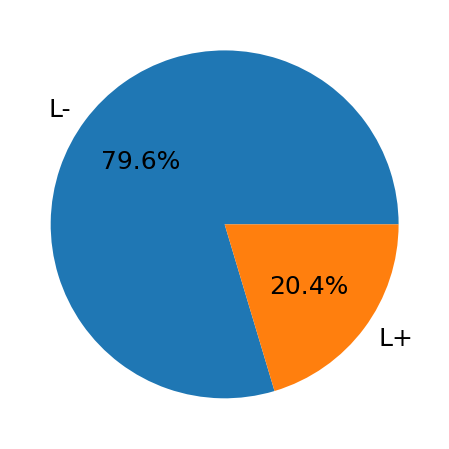

In [108]:
sizes = [2683200, 686400]
fontdict_labels = {'fontsize': 25}
fig, ax = plt.subplots(figsize=(8,8))
color_palette = ['#1e81b0', '#e28743', '#9BC1BC', '#5CA4A9', '#E6EBE0']
color_palette = ['#5CA4A9', '#ED6A5A', '#9BC1BC', '#5CA4A9', '#E6EBE0']
ax.pie(sizes, labels=["L-","L+"],
        autopct='%1.1f%%', textprops=fontdict_labels)
plt.show()

In [21]:
false_negs.to_csv("../data/HC-ALL-negative_ar.csv")
positive_ar.to_csv("HC-ALL-positive_ar.csv")

del false_negs
del positive_ar

In [31]:
pos_ar = pd.read_csv("../data/HC-ALL-positive_ar.csv")
print(pos_ar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686400 entries, 0 to 686399
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   686400 non-null  int64 
 1   position     686400 non-null  object
 2   uward        686400 non-null  object
 3   specialties  686400 non-null  object
 4   teams        686400 non-null  object
 5   agentfor     686400 non-null  object
 6   uname        686400 non-null  int64 
 7   type         686400 non-null  object
 8   author       686400 non-null  object
 9   patient      686400 non-null  object
 10  topics       686400 non-null  object
 11  tratingTeam  686400 non-null  object
 12  rward        686400 non-null  object
 13  rname        686400 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 73.3+ MB
None


In [25]:
pos_ar.rname.value_counts()

2121    426
2461    426
2477    426
2475    426
2473    426
       ... 
3464    234
3466    234
3468    234
3470    234
4119    234
Name: rname, Length: 2080, dtype: int64

<BarContainer object of 2080 artists>

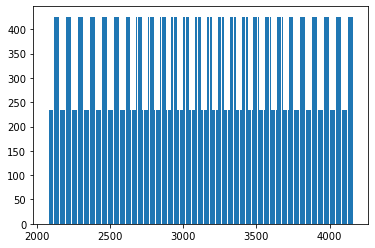

In [26]:
plt.bar(pos_ar.rname.value_counts().index, pos_ar.rname.value_counts())

In [46]:
sum(pos_ar.rname.value_counts()), len(pos_ar)

(686400, 686400)

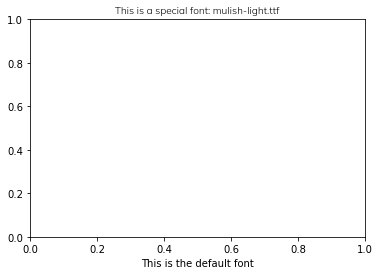

In [62]:
from pathlib import Path
import matplotlib as mpl

fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")
fpath2 = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


In [116]:
pos_ar.rname.drop_duplicates()

0        2080
1        2082
2        2084
3        2086
4        2088
         ... 
17764    4087
17769    4095
17774    4103
17779    4111
17784    4119
Name: rname, Length: 2080, dtype: int64

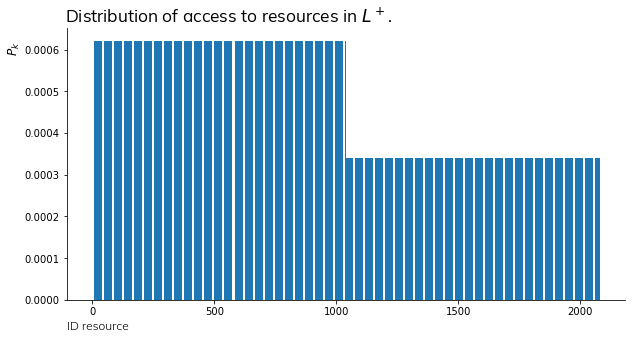

In [111]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = pos_ar.rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
plt.savefig("HC-AccessDistribution.svg")
plt.show()

<BarContainer object of 768 artists>

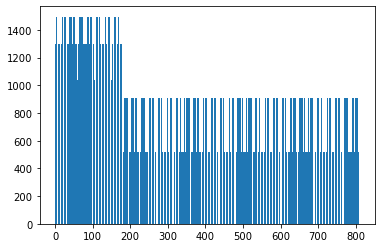

In [28]:
plt.bar(pos_ar.uname.value_counts().index, pos_ar.uname.value_counts())

In [147]:
a = false_negs[false_negs.type=="HR"]
a = a[a.teams!="None"]
a[["teams", "tratingTeam"]]

,teams,tratingTeam
71,oncTeam1,oncTeam2
75,oncTeam1,carTeam1
79,oncTeam1,carTeam2
83,oncTeam2,oncTeam1
91,oncTeam2,carTeam1
95,oncTeam2,carTeam2
103,oncTeam1,oncTeam2
107,oncTeam1,carTeam1
111,oncTeam1,carTeam2
115,oncTeam2,oncTeam1


In [52]:
class User:
    def __init__(self, name, position , uward , specialties , teams , agentfor) -> None:
        self.name = name
        self.position = position
        self.ward = uward
        self.specialties = specialties
        self.teams = teams
        self.agentfor = agentfor        

    def __str__(self) -> str:
        return self.name

class Users:
    def __init__(self, dataframe) -> None:
        self.df = dataframe
        self.attrs = dataframe.columns
        self.users = []        
    
    def build_list(self) -> None:
        """Create a list of user object"""
        rows = self.df.values        
        for i in rows:
            self.users.append(User(i[0], i[1], i[2], i[3], i[4], i[5]))
        print("Done")

    def users_size(self):
        return len(self.users)
    
class Rule:
    def __init__(self, attribute_expression) -> None:
        rule = []
        for item in attribute_expression: # For each attribute expression
            if item[0] == 0: # attribute = value

        pass

In [ ]:
policy = [
    [
        [0, "adminroles", "manager"],
        [0, "type", "budget"],
        [1, "department", "department"]
    ],
    [
        [0, "type", "schedule"],
        [1, "projectsled", "project"]
    ],
    [
        [0, "type", "budget"],
        [1, "projectsled", "project"]
    ],
    [
        [0, "type", "schedule"],
        [0, "projects", "project"]
    ],
    [
        [0, "type", "task"],
        [0, "tasks", "rname"]
    ],
    [
        [0, "type", "task"],
        [0, "proprietary", 0],
        [1, "poject", "projects"],
        [1, "expertise", "expertise"]
    ],
    [
        [0, "iseployee", 0],
        [0, "type", "task"],
        [1, "project", "projects"],
        [1, "expertise", "expertise"]
    ],
    [
        [0, "adminroles", "auditor"],
        [0, "type", "budget"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "budget"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "task"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "schedule"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "task"],
        [1, "project", "projects"]
    ]
]

In [ ]:
policy_uni = [
    
]